In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now()}')

Päivitetty 2021-10-27 12:42:33.691536


<h1>Kolminkertainen eksponentiaalinen tasoitus</h1>

Kolminkertaista eksponentiaalista tasoitusta kutsutaan myös <b>Holt-Winterin malliksi</b>. Eksponentiaalisen tasoituksen mallit (yksinkertainen, kaksinkertainen ja kolminkertainen) ovat erityisen suosittuja liiketaloudessa kysynnän ennustamisessa. Mallit ovat helppokäyttöisiä, nopeasti laskettavissa ja helposti päivitettävissä uusien havaintojen myötä.

Holt-Winterin malli huomioi sekä trendin että kausivaihtelun.

Eksponentiaalinen tasoitus löytyy <b>statsmodels.tsa</b>-kirjastosta.

Lisätietoa https://tilastoapu.wordpress.com/2018/08/30/aikasarjaennustaminen-3/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

%matplotlib inline

plt.style.use('seaborn-whitegrid')

<h2>Aikasarjaan tutustuminen</h2>

In [3]:
df = pd.read_excel('http://taanila.fi/aikasarja.xlsx')
df.head()

,Vuosineljännes,Kysyntä
0,2013-12-31,500
1,2014-03-31,350
2,2014-06-30,250
3,2014-09-30,400
4,2014-12-31,450


In [4]:
# Aikaleimat indeksiin
# to_datetime muuntaa merkkijonomuotoisen tiedon aikaleimoiksi
# format mahdollistaa erilaisten esitysmuotojen tunnistamisen aikaleimoiksi
df.index = pd.to_datetime(df['Vuosineljännes'], format = "%Y-%m-%d")

# Pudotetaan tarpeettomaksi käynyt sarake pois
df = df.drop('Vuosineljännes', axis = 1)
df.head()

,Kysyntä
Vuosineljännes,
2013-12-31,500
2014-03-31,350
2014-06-30,250
2014-09-30,400
2014-12-31,450


<AxesSubplot:xlabel='Vuosineljännes'>

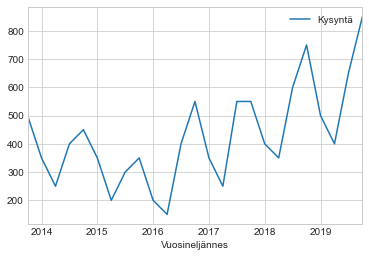

In [5]:
df.plot()

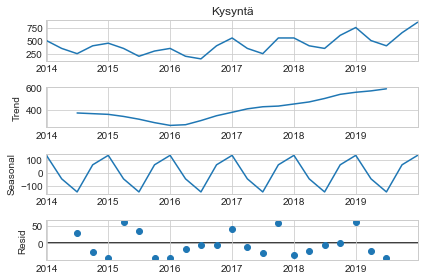

In [6]:
# Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
# Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
# Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu

decompose = seasonal_decompose(df['Kysyntä']).plot()

Tässä aikasarjassa on selvästi havaittavat trendi ja kausivaihtelu. Koska kyse on vuosineljänneksittäisestä datasta, niin kausivaihtelu esiintyy neljän havainnon (vuosineljänneksen) jaksoissa.

<h2>Mallin sovitus</h2>

Ennustemalli sovitetaan (<b>fit()</b>) dataan.
Tuloksena saadaan olio (tässä olen antanut oliolle nimeksi <b>malli</b>), joka sisältää monenlaista tietoa mallista.

Trendiin (<b>trend</b>) käytän summamallia (<b>add</b>), jossa trendi on aikasarjaan lisättävä termi. Tämä on suositeltavin vaihtoehto.

Kausivaihteluun (<b>seasonal</b>) käytän summamallia (<b>add</b>) tai tulomallia (<b>mul</b>). Tulomallissa kausivaihtelu ilmenee kertoimina. Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.

<b>seasonal_periods</b>-parametrille käytän arvoa 4, koska kausivaihtelu esiintyy neljän vuosineljänneksen jaksoissa.

<b>freq</b>-parametrille käytän arvoa <b>'Q'</b>, koska kyseessä ovat vuosineljänneksien viimeiset päivät. Lisätietoa <b>freq</b>-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [7]:
malli = ExponentialSmoothing(df['Kysyntä'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 4, freq='Q').fit()


C:\Users\Aki\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [8]:
# malli-olion avulla saan mallin mukaan simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille
df['Ennuste'] = malli.fittedvalues
df

,Kysyntä,Ennuste
Vuosineljännes,,
2013-12-31,500,500.233428
2014-03-31,350,343.348626
2014-06-30,250,264.968947
2014-09-30,400,447.008075
2014-12-31,450,497.144440
2015-03-31,350,314.179496
2015-06-30,200,262.120076
2015-09-30,300,371.652191
2015-12-31,350,382.469106


<AxesSubplot:xlabel='Vuosineljännes'>

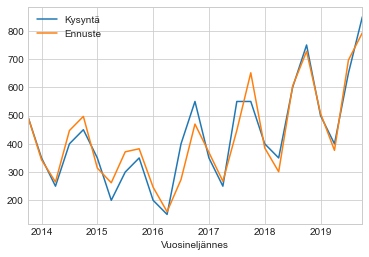

In [9]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon
df.plot()

In [10]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,Kysyntä,Ennuste,Ennustevirhe
Vuosineljännes,,,
2013-12-31,500,500.233428,-0.233428
2014-03-31,350,343.348626,6.651374
2014-06-30,250,264.968947,-14.968947
2014-09-30,400,447.008075,-47.008075
2014-12-31,450,497.144440,-47.144440
2015-03-31,350,314.179496,35.820504
2015-06-30,200,262.120076,-62.120076
2015-09-30,300,371.652191,-71.652191
2015-12-31,350,382.469106,-32.469106


<h2>Mallin tarkastelu</h2>

Mallin hyvyyden tarkasteluun on monia tapoja. Tässä käytän
<ul><li>ennustevirheiden aikasarjaa viivakaaviona</li>
    <li>ennusteiden ja toteutuneiden arvojen hajontakaaviota</li>
    <li>malliin liittyvää statistiikkaa, jonka saan <b>summary()</b>-toiminnolla.</li>
</ul>
Huomaa erityisesti <b>SSE</b> (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.

Text(0, 0.5, 'Ennustevirhe')

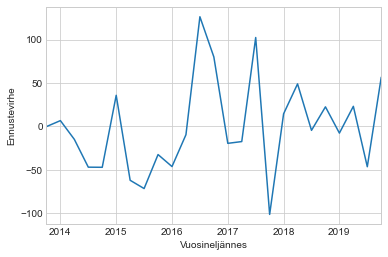

In [11]:
# Ennustevirheet aikasarjana
# On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut kysyntä')

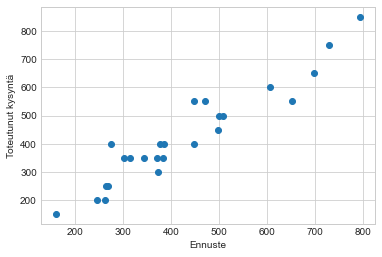

In [12]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio
# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
# vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['Kysyntä'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut kysyntä')

In [13]:
# Mallin statistiikkaa
malli.summary()

Dep. Variable:,Kysyntä,No. Observations:,25
Model:,ExponentialSmoothing,SSE,71238.850
Optimized:,True,AIC,214.873
Trend:,Additive,BIC,224.624
Seasonal:,Multiplicative,AICC,230.587
Seasonal Periods:,4,Date:,"Wed, 27 Oct 2021"
Box-Cox:,False,Time:,12:42:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8678296,alpha,True
smoothing_trend,0.0002318,beta,True


<h2>Ennusteiden laskeminen</h2>

Ennustettavien ajankohtien aikaleimojen määrittämiseksi:
<ul><li>Ensimmäisen ennustettavan ajankohdan aikaleiman täytyy olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.</li>
    <li>Ennustettavien ajankohtien lukumäärän voin määrittää <b>periods</b>-parametrilla.</li>
    <li>Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty <b>freq</b>-parametrin arvo.</li></ul>
        
Lisätietoa <b>freq</b>-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [14]:
#Tarkistan viimeisen aikaleiman
df.tail()

,Kysyntä,Ennuste,Ennustevirhe
Vuosineljännes,,,
2018-12-31,750,727.465971,22.534029
2019-03-31,500,507.735170,-7.735170
2019-06-30,400,376.867471,23.132529
2019-09-30,650,696.505144,-46.505144
2019-12-31,850,793.281338,56.718662


In [15]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)
index = pd.date_range('2020-03-31', periods = 8, freq = 'Q')

# Ennusteet kahdeksalle vuosineljännekselle
ennusteet = malli.forecast(8)

# Ennusteet tietokehikkoon (dataframe)
df_ennuste = pd.DataFrame(data = ennusteet, index = index, columns = ['Ennuste'])
df_ennuste

C:\Users\Aki\anaconda3\envs\env1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,Ennuste
2020-03-31,571.291514
2020-06-30,428.642765
2020-09-30,751.059797
2020-12-31,905.759037
2021-03-31,613.394087
2021-06-30,459.661037
2021-09-30,804.443664
2021-12-31,969.014604


<AxesSubplot:xlabel='Vuosineljännes'>

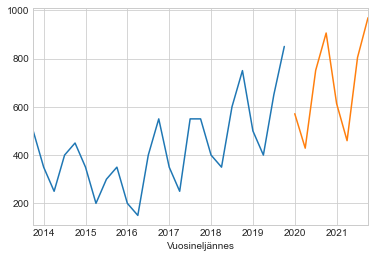

In [16]:
# Viivakaavio havainnoista
df['Kysyntä'].plot()

# Ennusteet kaavioon
df_ennuste['Ennuste'].plot()

In [17]:
# Tietokehikko, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([df, df_ennuste])
df1

,Kysyntä,Ennuste,Ennustevirhe
2013-12-31,500.0,500.233428,-0.233428
2014-03-31,350.0,343.348626,6.651374
2014-06-30,250.0,264.968947,-14.968947
2014-09-30,400.0,447.008075,-47.008075
2014-12-31,450.0,497.144440,-47.144440
2015-03-31,350.0,314.179496,35.820504
2015-06-30,200.0,262.120076,-62.120076
2015-09-30,300.0,371.652191,-71.652191
2015-12-31,350.0,382.469106,-32.469106
2016-03-31,200.0,246.305387,-46.305387


<h2>Lisätietoa</h2>

Data-analytiikka Pythonilla: https://tilastoapu.wordpress.com/python/